In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [263]:
## universal constants
e2 = 1.4399764 # MeV*fm
a = 0.7 # fm
hbarmpic = 2.044 #fm^2 (hbar/m_pi c)^2
V0 = 54 # MeV
## R = 1.2A^1/3
Vso = 0.2*V0
Num = 200000 # number for the number of steps in an integration calculation

df = pd.read_csv("sphericalprotonemitters.csv")
print(df)

    Z    A      Q  l    j     Texpt    dTdown       dTup
0  53  109  0.829  2  2.5  0.000109  0.000017   0.000017
1  55  113  0.977  4  3.5  0.000033  0.000007   0.000007
2  69  147  1.071  5  5.5  2.700000  0.900000   2.400000
3  69  147  1.139  2  1.5  0.000360  0.000080   0.000080
4  71  150  1.285  5  5.5  0.010000  0.000000  10.000000
5  71  151  1.255  5  5.5  0.120000  0.040000   0.120000
6  73  156  1.015  2  1.5  0.165000  0.055000   0.165000
7  75  160  1.250  2  1.5  0.000870  0.000170   0.000230


In [264]:
print(df.iloc[0].values)

[5.30e+01 1.09e+02 8.29e-01 2.00e+00 2.50e+00 1.09e-04 1.70e-05 1.70e-05]


In [265]:
## functions

def WoodsSaxonFunc(r,R):
    return 1./(1+np.exp((r-R)/a))

def WoodsSaxonPotential(r,R,l,j):
    dr = 0.000001*r
    ddrFws = (WoodsSaxonFunc(r+dr,R)-WoodsSaxonFunc(r-dr,R))/(2*dr)
    s = j-l
    ls = (1/2)*(j*(j+1)-l*(l+1)-s*(s+1))
    return -V0*WoodsSaxonFunc(r,R)+Vso*hbarmpic*(2/r)*ddrFws*(ls)
print(WoodsSaxonPotential(2.5,5.7,2,2.5))

def Vcoul(r,R,Z):
    if r > R:
        return Z*e2/r
    else:
        return Z*e2/(2*R)*(3-(r/R)**2)

def Vtot(r,R,Z,l,j):
    return WoodsSaxonPotential(r,R,l,j)+Vcoul(r,R,Z)+(1/(2*r**2))*(197.**2)/(938.3)*l*(l+1)

def k(r,Q,R,Z,l,j):
    return np.sqrt(2*(938/(197*197))*np.abs((Q-Vtot(r,R,Z,l,j))))

def N(r0,r1,Q,R,Z,l,j):
    rspace = np.linspace(r0,r1,Num)
    Nsum = 0
    dr = rspace[1]-rspace[0]
    Nsum = dr/(3*k(rspace[0],Q,R,Z,l,j))
    Nsum += dr/(3*k(rspace[-1],Q,R,Z,l,j))
    for i in range(1,Num-1):
        if i%2 == 1:
            fac = 4
        else:
            fac = 2
        step = (fac/3)*dr/k(rspace[i],Q,R,Z,l,j)
        Nsum += step
    Ninv = (.5)*Nsum
    return 1/Ninv

def Gamma(Sp,r0,r1,r2,Q,R,Z,l,j):
    rspace = np.linspace(r1,r2,Num)
    dr = rspace[1] - rspace[0]
    Nterm = N(r0,r1,Q,R,Z,l,j)
    
    massterm = Sp*197*197/(4*938)
    Nsum = (dr/3)*np.real(k(rspace[0],Q,R,Z,l,j))/2
    Nsum += (dr/3)*np.real(k(rspace[-1],Q,R,Z,l,j))/2
    for i in range(0,Num):
        if i%2 == 1:
            fac = 4
        else:
            fac = 2
        step = (fac*dr/3)*np.real(k(rspace[i],Q,R,Z,l,j))
        Nsum += step
    #print(Nsum)
    return massterm*Nterm*np.exp(-2*Nsum)


-53.702816934323906


In [266]:
def zerofinder(Vtot,R,Z,l,j,guess,E,thresh):
    variable = True
    ro=guess
    while variable:
        if np.abs(Vtot(ro,R,Z,l,j)-E) < thresh:
            variable = False
        else:
            dr = .000001
            ddr = (Vtot(ro+dr,R,Z,l,j)-Vtot(ro-dr,R,Z,l,j))/(2*dr)
            ro = ro-Vtot(ro,R,Z,l,j)/ddr + E/ddr
        #print(Vtot(ro,R,Z,l,j))
    return ro

def CalcHalfLife(Sp,Z,A,Q,l,j):
    R = 1.2*A**(1/3)
    r0 = zerofinder(Vtot,R,Z,l,j,.5,Q,0.0001)
    r1 = zerofinder(Vtot,R,Z,l,j,6.2,Q,0.0001)
    r2 = zerofinder(Vtot,R,Z,l,j,100,Q,0.0001)
    print(r0)
    print(r1)
    print(r2)
    gamma = Gamma(Sp,r0,r1,r2,Q,R,Z,l,j)
    hbar = (6.582*10**(-22))*np.log(2) # MeV s
    return hbar/gamma,r0

#print(CalcHalfLife(1,71,151,1.255,5,5.5))

In [267]:
InitLifetime = np.zeros(len(df))
for i in range(0,len(df)):
    args = df.iloc[i].values
    InitLifetime[i] = CalcHalfLife(1,args[0],args[1],args[2],args[3],args[4])[0]

1.8699693945380573
6.61653785618391
93.65725828159022
3.4984336842075665
5.517821393751453
85.9864978807903
4.261562422299423
6.561753765884649
98.64406465137967
1.9632515675204734
6.806213844027819
88.46443608417408
4.275268406270661
6.606237121735163
85.22775739027935
4.274139190188486
6.6239378553243
87.1380021891436
1.9930951414130376
6.891122041656027
104.7316105497576
1.9997237584247674
6.94572444597838
87.53261721919633


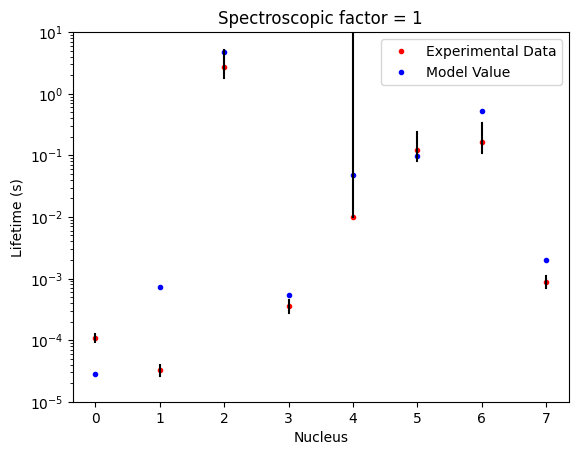

In [268]:
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
for i in range(0,len(df)):
    args = df.iloc[i].values
    ax.plot(i,args[-3],'r.',label="Experimental Data" if i == 0 else None)
    ax.plot(i,InitLifetime[i],'b.',label="Model Value" if i == 0 else None)
    errorx = [i,i]
    errory = [args[-3]-args[-2],args[-3]+args[-1]]
    ax.plot(errorx,errory,'black')
ax.set_ylim(.00001,10)
ax.set_xlabel("Nucleus")
ax.set_ylabel("Lifetime (s)")
ax.set_title("Spectroscopic factor = 1")
ax.legend()
plt.show()

In [269]:
for i in range(0,len(df)):
    args = df.iloc[i].values
    print("For Z = {} and A = {}, lifetime is {:.3e}".format(args[0],args[1],InitLifetime[i]))

For Z = 53.0 and A = 109.0, lifetime is 2.825e-05
For Z = 55.0 and A = 113.0, lifetime is 7.181e-04
For Z = 69.0 and A = 147.0, lifetime is 4.716e+00
For Z = 69.0 and A = 147.0, lifetime is 5.453e-04
For Z = 71.0 and A = 150.0, lifetime is 4.783e-02
For Z = 71.0 and A = 151.0, lifetime is 9.744e-02
For Z = 73.0 and A = 156.0, lifetime is 5.286e-01
For Z = 75.0 and A = 160.0, lifetime is 1.982e-03


In [179]:
# r0 = 3.393
# r1 = 5.613
# r2 = 241.74
R = 1.2*109**(1/3)
print(k(30.73222,.829,5.73222,53,2,2.5))
print(Vtot(5.8322,5.7322,53,2,2.5))
print(R)
print(Gamma(1,1.87,6.6165,93.66,.829,R,53,2,2.5))
print(6.582*10**(-22)*np.log(2)/Gamma(1,1.87,6.6165,93.66,.829,R,53,2,2.5))

0.2938038393722664
-11.030873243088529
5.73222741724202
1.619441191566892e-17
2.8172030983300517e-05


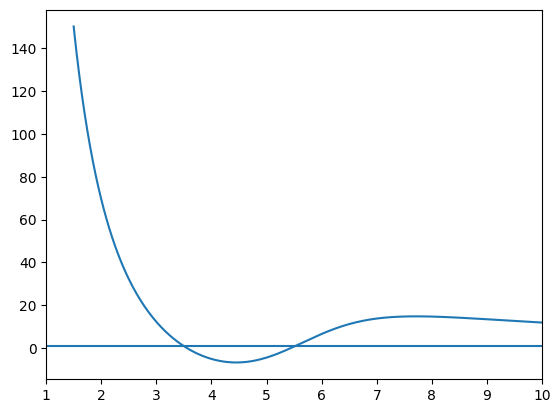

In [219]:
rspace = np.linspace(1.5,250,10000)
Vtotspace = np.zeros(10000)
#Vcoulspace = np.zeros(10000)
#Vws = np.zeros(10000)
#VSO = np.zeros(10000)
for i in range(0,10000):
    R = 1.2*113**(1/3)
    Vtotspace[i] = Vtot(rspace[i],R,55,4,3.5)
#    Vcoulspace[i] = Vcoul(rspace[i],R,53)
#    Vws[i] = WoodsSaxonPotential(rspace[i],R,2,2.5)
#    VSO[i] = Vtotspace[i] - Vcoulspace[i] - Vws[i]
    
plt.figure(1)
plt.plot(rspace,Vtotspace)
#plt.plot(rspace,Vcoulspace)
#plt.plot(rspace,Vws,'r')
#plt.plot(rspace,VSO,'b')
plt.axhline(.977)
plt.xlim(1,10)
#plt.ylim(.828,.830)
plt.show()

In [24]:
np.sqrt((197*197)/2.044)

137.7925636841612